# 모듈

In [76]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import ace_tools_open as tools
from fredapi import Fred

from scipy import stats
from scipy.stats import shapiro

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA 

from sklearn.pipeline import Pipeline
from sklearn import svm

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, recall_score, precision_score, adjusted_rand_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [41]:
# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 데이터 읽기

In [ ]:
df_quarter = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=0) # 분기별 데이터
df_month = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=1) # 월별 데이터
df_month_2024 = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=5) # 2024년 데이터(검증용)
df_q_add = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=2)
df_mon_chg = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=3)
df_month_omiss = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=4)


# 상관관계 시각화

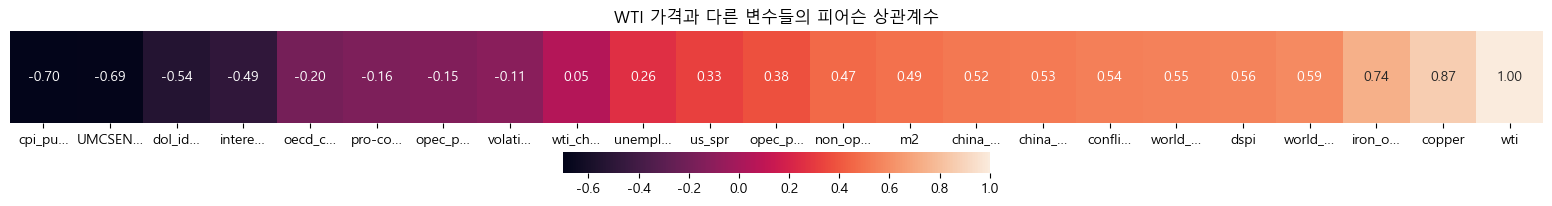

In [167]:
df_month_a = df_month.iloc[:, 5:]
df_month_corr = df_month_a.corr()[['wti']].sort_values(by = 'wti', ascending = True).T
fig, ax = plt.subplots(figsize=(16, 2))
plt.tight_layout()
sns.heatmap(df_month_corr, annot=True, fmt=".2f", yticklabels=False, cbar_kws={"orientation": "horizontal", "pad": 0.2})
xtick_labels = [label.get_text()[:6] + "…" if len(label.get_text()) > 6 else label.get_text() 
                for label in ax.get_xticklabels()]

# ✅ X축 라벨 업데이트 및 가독성 조정
ax.set_xticklabels(xtick_labels, rotation=0, ha='center')
plt.title("WTI 가격과 다른 변수들의 피어슨 상관계수")

plt.show()

In [168]:
# ✅ 컬럼 한글화 진행
column_mapping = {
    "date": "날짜",
    "year": "연도",
    "quarter": "분기",
    "month": "월",
    "total_manu": "제조업 생산량",
    "dol_idx": "달러 지수",
    "m2": "M2 통화량",
    "unemploy": "실업률",
    "interest": "금리",
    "copper": "구리 가격",
    "cpi_purch_power": "구매력 지수",
    "dspi": "개인 소득",
    "iron_ore": "철광석 가격",
    "UMCSENT": "소비자 심리지수",
    "us_spr": "미국 전략 비축유",
    "conflicts": "국제 갈등 횟수",
    "world_production": "세계 원유 생산량",
    "opec_production": "OPEC 원유 생산량",
    "non_opec_producion": "비OPEC 원유 생산량",
    "opec_pro_ratio": "OPEC 생산 비율",
    "world_consumption": "세계 원유 소비량",
    "oecd_consumption": "OECD 원유 소비량",
    "china_consumption": "중국 원유 소비량",
    "china_con_ratio": "중국 소비 비율",
    "pro-con": "원유 생산-소비 차이",
    "wti": "WTI 유가",
    "wti_change": "WTI 가격 변화"
}

# ✅ df의 컬럼명을 변경한 새로운 데이터프레임 df_tr 생성
df_tr = df_month.rename(columns=column_mapping, inplace=False)

# ✅ 원래 컬럼명과 한글 변환 리스트 출력
column_translation = pd.DataFrame(list(column_mapping.items()), columns=["컬럼", "한글"])

# ✅ 변환된 데이터 출력
# 10열씩 나누어 출력
for i in range(0, column_translation.shape[1], 10):
    print(column_translation.iloc[:, i:i+10].T.to_string(index=False))
    print("\n" + "="*50 + "\n")  # 구분선 추가


  0    1       2     3          4       5      6        7        8      9               10    11       12       13        14        15               16              17                 18             19                20               21                22              23          24     25         26
date year quarter month total_manu dol_idx     m2 unemploy interest copper cpi_purch_power  dspi iron_ore  UMCSENT    us_spr conflicts world_production opec_production non_opec_producion opec_pro_ratio world_consumption oecd_consumption china_consumption china_con_ratio     pro-con    wti wti_change
  날짜   연도      분기     월    제조업 생산량   달러 지수 M2 통화량      실업률       금리  구리 가격          구매력 지수 개인 소득   철광석 가격 소비자 심리지수 미국 전략 비축유  국제 갈등 횟수        세계 원유 생산량     OPEC 원유 생산량       비OPEC 원유 생산량     OPEC 생산 비율         세계 원유 소비량      OECD 원유 소비량         중국 원유 소비량        중국 소비 비율 원유 생산-소비 차이 WTI 유가  WTI 가격 변화




# EDA 작업 수행

In [248]:
# filter = ['date', 'year', 'quarter', 'month', 'total_manu', 'dol_idx', 'm2',
#        'unemploy', 'interest', 'copper', 'cpi_purch_power', 'dspi', 'iron_ore',
#        'UMCSENT', 'us_spr', 'conflicts', 'world_production', 'opec_production',
#        'non_opec_producion', 'opec_pro_ratio', 'world_consumption',
#        'oecd_consumption', 'china_consumption', 'china_con_ratio', 'pro-con',
#        'wti', 'wti_change']

# filter = ['date', 'year', 'quarter', 'month',  'dol_idx', 'm2',
#        'unemploy', 'interest', 'copper', 'cpi_purch_power', 'dspi', 'iron_ore',
#        'UMCSENT', 'us_spr', 'conflicts', 'world_production', 'opec_production',
#        'non_opec_producion','world_consumption',
#         'china_consumption', 'china_con_ratio',
#        'wti', 'wti_change']

filter = ['date', 'year', 'quarter', 'month',  'm2',
       'unemploy', 'interest', 'copper', 
       'UMCSENT', 'conflicts', 
        'pro-con',  'wti', 'wti_change', 
       ]
        # 'volatility',
df_vif = df_month.dropna()[filter].iloc[:,4:-2] # 4번까지는 날짜 정보 / -2번: 유가 / -1번: 유가 오르고 내림 (0 or 1)

variance_inflation_factor(df_vif.values, 0)


# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif_data)

     feature        VIF
0         m2  14.500491
1   unemploy  11.901723
2   interest   4.007541
3     copper  14.458629
4    UMCSENT  19.390581
5  conflicts   7.759285
6    pro-con   1.086784


Mean Squared Error: 123.66839138023634
Mean Absolute Error: 8.603074531532917
Root Mean Squared Error: 11.120629091028814
R-squared Score: 0.6531907111267272


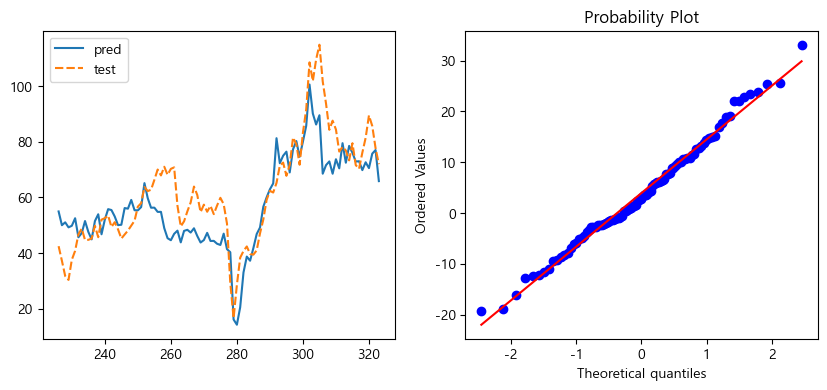

Statistics=0.990, p=0.643


In [249]:
df_month = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=1) # 월별 데이터
df_month_2024 = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=5) # 2024년 데이터(검증용)

tt_rate = 0.3

# 일반 선형 회귀 모델

df_m = df_month.dropna()[filter].iloc[:,:]
# df_m['copper'] = df_m['copper'].apply(lambda x: np.log(x))
df_X = df_m.iloc[:,4:-2] # 날짜 및 wti 가격정보 제거
df_y = df_m.iloc[:,-2] # wti 가격 가져오기

# df_month_2024 = df_month_2024.dropna()
# df_X_validate = df_month_2024.iloc[:,4:-2] # 날짜 및 wti 가격정보 제거
# df_y_validate = df_month_2024.iloc[:,-2]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size =tt_rate, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
pred = lm.predict(X_test_scaled)

# 성능 평가 지표 계산
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

# 결과 출력
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")


df_plot = pd.DataFrame(pred, columns=['pred'])
df_plot['test'] = y_test.reset_index(drop=True)
df_plot.index = y_test.index
residuals = y_test - pred
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(df_plot, ax=ax1)
stats.probplot(residuals, plot=ax2, )
plt.show()

stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# p-value가 0.05보다 크면 정규성을 따른다고 해석할 수 있습니다.

Mean Squared Error: 126.64719279933847
Mean Absolute Error: 9.537130218612889
Root Mean Squared Error: 11.253763494908647
R-squared Score: 0.6448371133292338


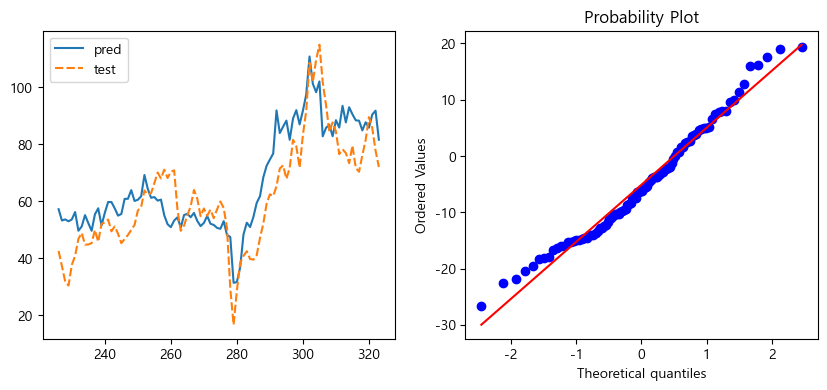

Statistics=0.976, p=0.068


In [250]:
# LASSO 모델

# df_X = df_month.iloc[:,4:-2]
# df_y = df_month.iloc[:,-2]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=tt_rate, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
pred = lasso.predict(X_test_scaled)

# 성능 평가 지표 계산
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

# 결과 출력
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

df_plot = pd.DataFrame(pred, columns=['pred'])
df_plot['test'] = y_test.reset_index(drop=True)
df_plot.index = y_test.index
residuals = y_test - pred
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(df_plot, ax=ax1)
stats.probplot(residuals, plot=ax2, )
plt.show()

stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# p-value가 0.05보다 크면 정규성을 따른다고 해석할 수 있습니다.

Mean Squared Error: 489.3995264565785
Mean Absolute Error: 19.089524291720927
Root Mean Squared Error: 22.122376148519365
R-squared Score: -0.3724469110580424


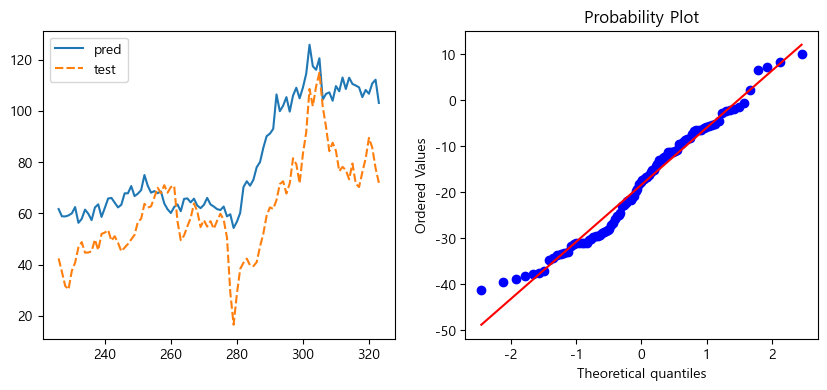

Statistics=0.972, p=0.035


In [251]:
# Ridge 모델

# df_X = df_month.iloc[:,4:-4]
# df_y = df_month.iloc[:,-2]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=tt_rate, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = Ridge(alpha=10)
ridge.fit(X_train_scaled, y_train)
pred = ridge.predict(X_test_scaled)

# 성능 평가 지표 계산
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

# 결과 출력
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

df_plot = pd.DataFrame(pred, columns=['pred'])
df_plot['test'] = y_test.reset_index(drop=True)
df_plot.index = y_test.index
residuals = y_test - pred
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(df_plot, ax=ax1)
stats.probplot(residuals, plot=ax2, )
plt.show()

stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# p-value가 0.05보다 크면 정규성을 따른다고 해석할 수 있습니다.

<Axes: >

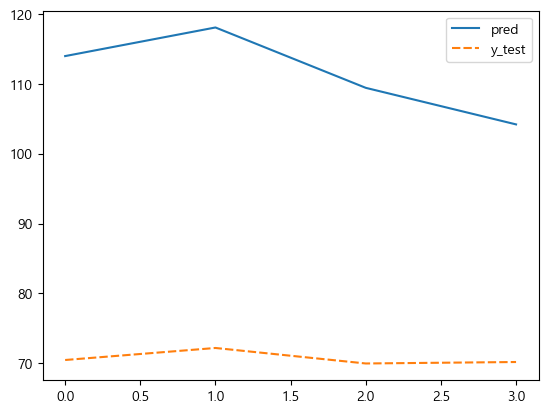

In [252]:
X_test_2024 = df_month_2024[filter].iloc[:,4:-2]
X_test_2024_scaled = scaler.transform(X_test_2024)

y_pred_2024 = ridge.predict(X_test_2024_scaled)
y_test_2024 = df_month_2024[filter].iloc[:,-2]

df_2024 = pd.DataFrame(y_pred_2024, columns=['pred'])
df_2024['y_test'] = y_test_2024

# df_2024['diff'] = df_2024['pred'] - df_2024['y_test']
# df_2024

sns.lineplot(df_2024)

In [253]:
y_test_2024

0    70.440000
1    72.164348
2    69.941429
3    70.152273
Name: wti, dtype: float64

In [257]:
X_test_2024

,m2,unemploy,interest,copper,UMCSENT,conflicts,pro-con
0,21165.8,4.1,5.13,9259.128571,70.1,2288,-0.64
1,21230.3,4.1,4.83,9533.991304,70.5,2516,0.67
2,21423.8,4.2,4.64,9075.727143,71.8,2112,-0.05
3,21619.0,4.1,4.48,8909.907727,74.0,1856,-1.40


In [255]:
ridge.coef_

array([-1.26547497e+00, -2.69191198e+00, -1.95112913e-01,  2.10289218e+01,
       -9.41547548e+00,  5.89369947e+00,  1.03577808e-02])

In [150]:
# K-Fold 교차 검증 설정 (예: 5-Fold)
kf = KFold(n_splits=5, shuffle=False)

# 교차 검증 수행
ridge_scores = cross_val_score(ridge, df_X, df_y, cv=kf)
lasso_scores = cross_val_score(lasso, df_X, df_y, cv=kf)
print(ridge_scores, ridge_scores.mean(), lasso_scores, lasso_scores.mean())

[-0.4682307   0.37703021  0.61871728  0.71859081  0.66264439] 0.38175039915051384 [-0.45752271  0.36932039  0.61842629  0.72098878  0.68911167] 0.38806488640983594


Mean Squared Error: 170.83349458313404
Mean Absolute Error: 10.481224695282645
Root Mean Squared Error: 13.070328786344055
R-squared Score: 0.5683377111955847


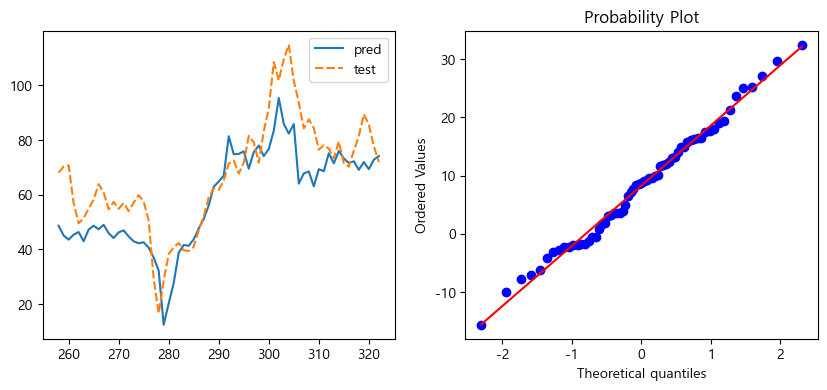

Statistics=0.990, p=0.877


In [223]:
# Ridge 모델 / 한달 후 유가와 비교

df_m = df_month.dropna()[filter]

gap = 1

df_X = df_m.iloc[:,4:-2]
df_y = df_m.iloc[:,-2]

df_X = df_X.iloc[:-gap,:]
df_y = df_y.iloc[gap:]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_1m = Ridge(alpha=1)
ridge_1m.fit(X_train_scaled, y_train)
pred = ridge_1m.predict(X_test_scaled)

mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

# 성능 평가 지표 계산
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

# 결과 출력
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

df_plot = pd.DataFrame(pred, columns=['pred'])
df_plot['test'] = y_test.reset_index(drop=True)
df_plot.index = y_test.index
residuals = y_test - pred
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(df_plot, ax=ax1)
stats.probplot(residuals, plot=ax2, )
plt.show()

stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# p-value가 0.05보다 크면 정규성을 따른다고 해석할 수 있습니다.

Mean Squared Error: 135.5089652113369
Mean Absolute Error: 9.520756421461115
Root Mean Squared Error: 11.640831809253879
R-squared Score: 0.6575957764056737


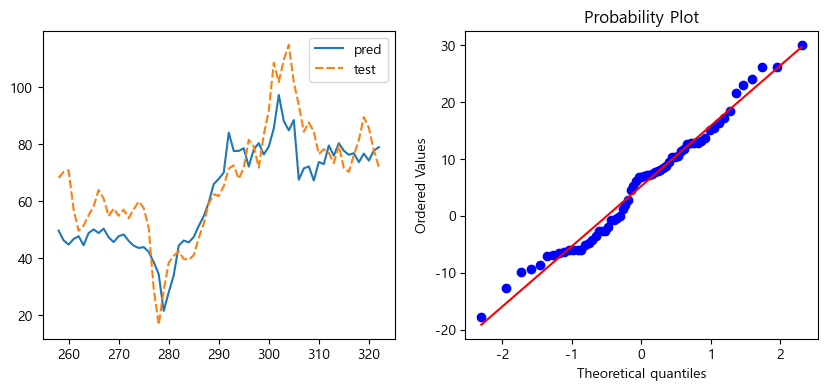

Statistics=0.979, p=0.330


In [224]:
# LASSO 모델 / 한달 후 유가와 비교

# df_X = df_month.iloc[:-1,4:-1]
# df_y = df_month.iloc[1:,-1]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_1m = Lasso(alpha=0.1)
lasso_1m.fit(X_train_scaled, y_train)
pred = lasso_1m.predict(X_test_scaled)

mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

# 성능 평가 지표 계산
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

# 결과 출력
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

df_plot = pd.DataFrame(pred, columns=['pred'])
df_plot['test'] = y_test.reset_index(drop=True)
df_plot.index = y_test.index
residuals = y_test - pred
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(df_plot, ax=ax1)
stats.probplot(residuals, plot=ax2, )
plt.show()

stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# p-value가 0.05보다 크면 정규성을 따른다고 해석할 수 있습니다.

<Axes: >

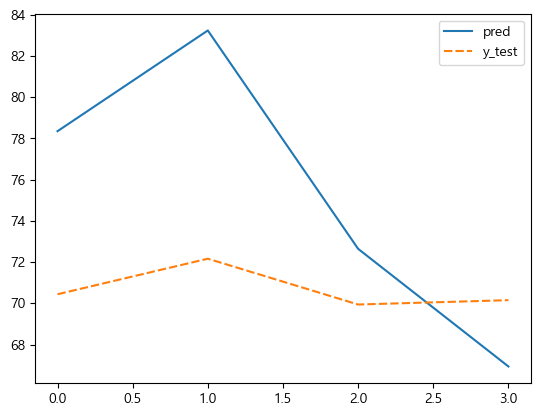

In [225]:
X_test_2024 = df_month_2024[filter].iloc[:,4:-2]
X_test_2024_scaled = scaler.transform(X_test_2024)

y_pred_2024 = ridge_1m.predict(X_test_2024_scaled)
y_test_2024 = df_month_2024[filter].iloc[:,-2]

df_2024 = pd.DataFrame(y_pred_2024, columns=['pred'])
df_2024['y_test'] = y_test_2024

# df_2024['diff'] = df_2024['pred'] - df_2024['y_test']
# df_2024

sns.lineplot(df_2024)

In [53]:
# K-Fold 교차 검증 설정 (예: 5-Fold)
kf = KFold(n_splits=5, shuffle=False)

# 교차 검증 수행
ridge_1m_scores = cross_val_score(ridge_1m, df_X, df_y, cv=kf)
lasso_1m_scores = cross_val_score(lasso_1m, df_X, df_y, cv=kf)
print(ridge_1m_scores, ridge_1m_scores.mean(), lasso_1m_scores, lasso_1m_scores.mean())

[-0.53408048  0.35803252  0.66871136  0.6984997   0.55907222] 0.35004706511872236 [-0.54167608  0.35698919  0.66784294  0.70301551  0.60109795] 0.35745390355789275


In [54]:
df_result = pd.DataFrame(columns=['name'])
df_result['name'] = df_X.columns.tolist()
df_result['lasso'] = lasso.coef_.tolist()
df_result['lasso_1m'] = lasso_1m.coef_.tolist()
df_result['ridge'] = ridge.coef_.tolist()
df_result['ridge_1m'] = ridge_1m.coef_.tolist()
df_result

,name,lasso,lasso_1m,ridge,ridge_1m
0,m2,-5.736216,-6.017400,-7.699344,-7.911068
1,unemploy,-4.209287,-2.961245,-5.107446,-3.861361
2,interest,-2.311458,-1.860288,-3.671818,-3.175129
3,copper,24.482152,24.720131,25.443236,25.603115
4,UMCSENT,-9.486038,-8.394137,-9.712960,-8.613991
5,conflicts,7.105945,6.916336,7.716171,7.538444
6,pro-con,0.203563,-0.809303,0.385253,-0.840224
7,volatility,-0.674767,-0.472751,-0.625510,-0.433857


정확도: 0.6020408163265306
정밀도: 0.725
재현도: 0.5087719298245614


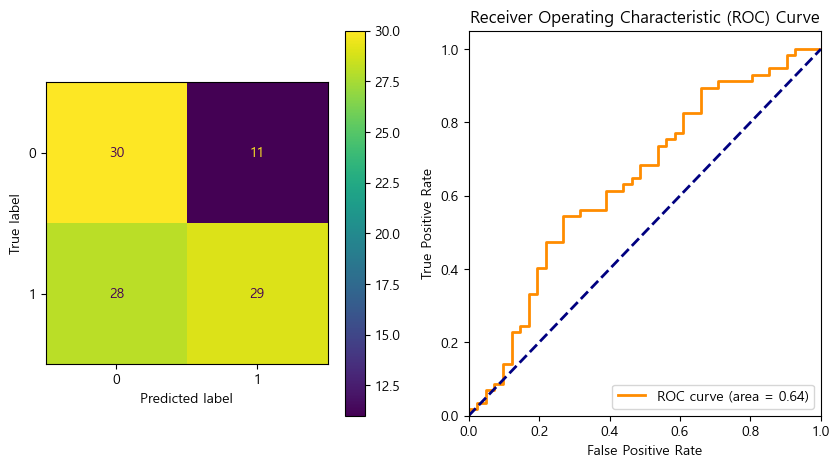

In [55]:
# 로지스틱 회귀 Ridge / 값 그대로

from sklearn.linear_model import LogisticRegression

df_m = df_month.dropna()[filter]

df_X = df_m.iloc[:,4:-2]
df_y = df_m.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge 로지스틱 회귀 모델 설정
ridge_lr = LogisticRegression(penalty='l2', C=1, random_state=17)  # C는 정규화의 역수; 낮을수록 더 강한 정규화
ridge_lr.fit(X_train_scaled, y_train)

y_pred = ridge_lr.predict(X_test_scaled)
y_pred_proba = ridge_lr.predict_proba(X_test_scaled)[:,1]

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr.classes_)
disp.plot(ax=ax1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

정확도: 0.6632653061224489
정밀도: 0.6764705882352942
재현도: 0.8070175438596491


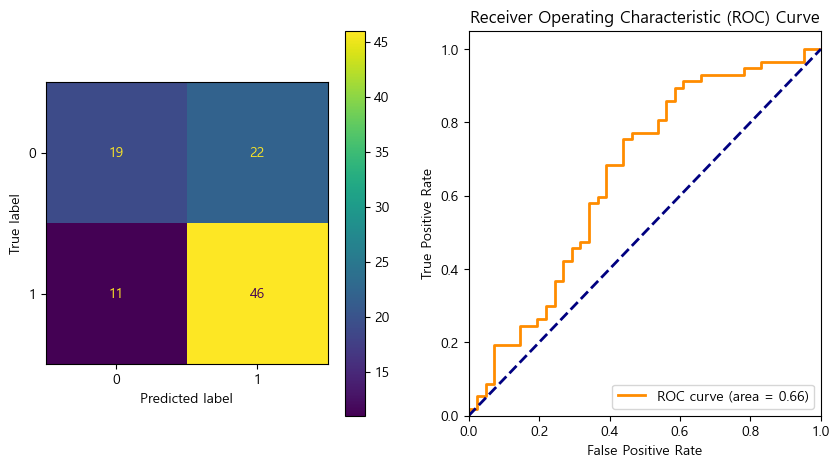

In [56]:
# LASSO 로지스틱 회귀 모델 설정  / 값 그대로

lasso_lr = LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=2380971)
lasso_lr.fit(X_train_scaled, y_train)

y_pred = lasso_lr.predict(X_test_scaled)
y_pred_proba = lasso_lr.predict_proba(X_test_scaled)[:,1]

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr.classes_)
disp.plot(ax=ax1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

정확도: 0.6804123711340206
정밀도: 0.6585365853658537
재현도: 0.9473684210526315


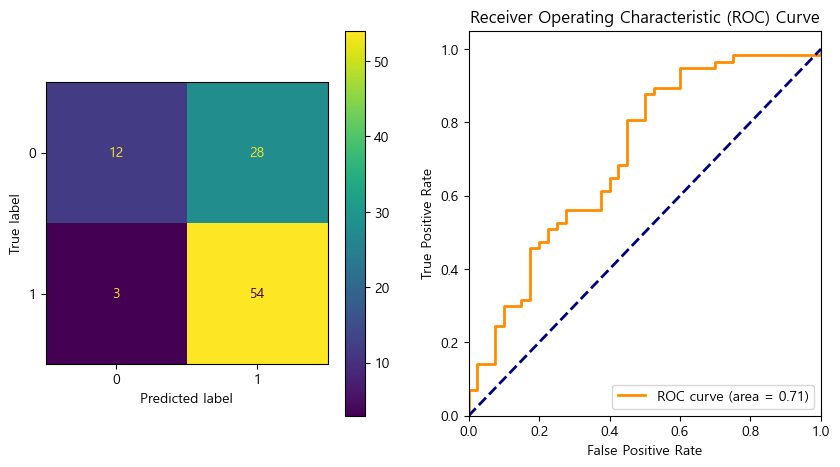

In [ ]:
# 로지스틱 회귀 Ridge / 한달 후

df_m = df_month.dropna()[filter]

gap = 1

df_X = df_m.iloc[:-gap,4:-2]
df_y = df_m.iloc[gap:,-1]


X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge 로지스틱 회귀 모델 설정
ridge_lr_1m = LogisticRegression(penalty='l2', C=1, random_state=17)  # C는 정규화의 역수; 낮을수록 더 강한 정규화
ridge_lr_1m.fit(X_train_scaled, y_train)

y_pred = ridge_lr_1m.predict(X_test_scaled)
y_pred_proba = ridge_lr_1m.predict_proba(X_test_scaled)[:,1]

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr.classes_)
disp.plot(ax=ax1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

정확도: 0.6391752577319587
정밀도: 0.6617647058823529
재현도: 0.7894736842105263


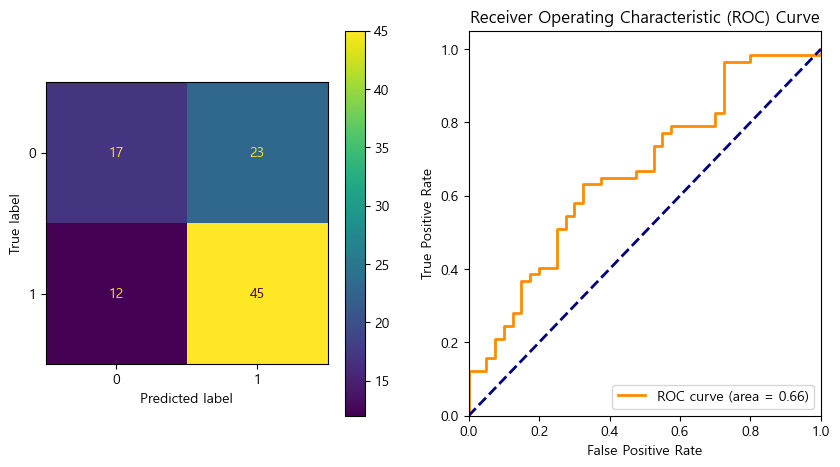

In [58]:
# LASSO 로지스틱 회귀 모델 설정 / 한달 후

lasso_lr_1m = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=2380971)
lasso_lr_1m.fit(X_train_scaled, y_train)

y_pred = lasso_lr_1m.predict(X_test_scaled)
y_pred_proba = lasso_lr_1m.predict_proba(X_test_scaled)[:,1]

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr.classes_)
disp.plot(ax=ax1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\kbh11\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


정확도: 0.5670103092783505
정밀도: 0.6363636363636364
재현도: 0.6140350877192983
최적의 파라미터: {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 10}
최적의 점수: 0.5314975845410628


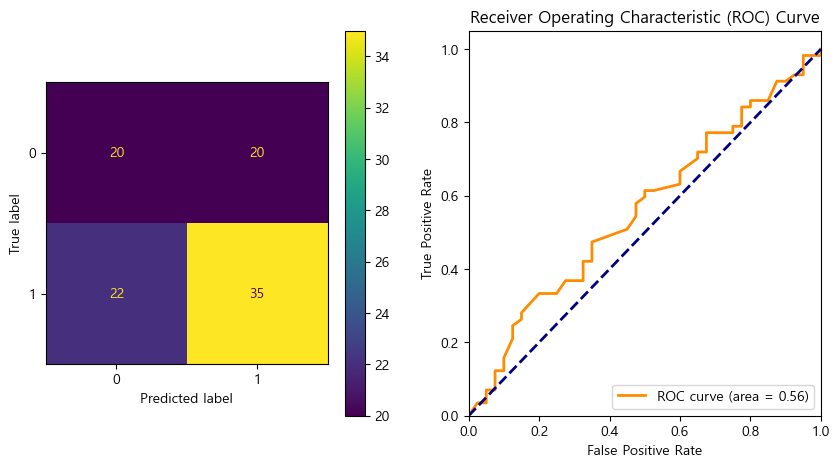

In [59]:
# Random Forest 분류 / 값 그대로대로

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

# 파이프라인 설정
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 데이터 스케일링
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))  # 랜덤 포레스트 모델
])

param_grid = {
    'rf__n_estimators': [10, 50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:,1]


print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

print("최적의 파라미터:", grid_search.best_params_)
print("최적의 점수:", grid_search.best_score_)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr.classes_)
disp.plot(ax=ax1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [64]:
df_coef = pd.DataFrame()
df_coef['name'] = filter[4:-2]
df_coef['ridge'] = ridge_lr.coef_.tolist()[0]
df_coef['ridge_1m'] = ridge_lr_1m.coef_.tolist()[0]
df_coef['lasso'] = lasso_lr.coef_.tolist()[0]
df_coef['lasso_1m'] = lasso_lr_1m.coef_.tolist()[0]

df_coef

,name,ridge,ridge_1m,lasso,lasso_1m
0,m2,-0.357631,0.432320,0.000000,0.000000
1,unemploy,-0.137445,0.243865,0.000000,0.000000
2,interest,-0.607361,-0.122096,-0.224760,0.000000
3,copper,0.541216,-0.069635,0.210588,0.000000
4,UMCSENT,0.536467,0.621996,0.356828,0.000000
5,conflicts,-0.236168,-0.453277,-0.210732,0.000000
6,pro-con,-0.354077,-0.673966,-0.348126,-0.363024
7,volatility,0.041544,0.087123,0.000000,0.000000


아래는 변화율로 분석 수행

정확도: 0.6224489795918368
정밀도: 0.7272727272727273
재현도: 0.5614035087719298


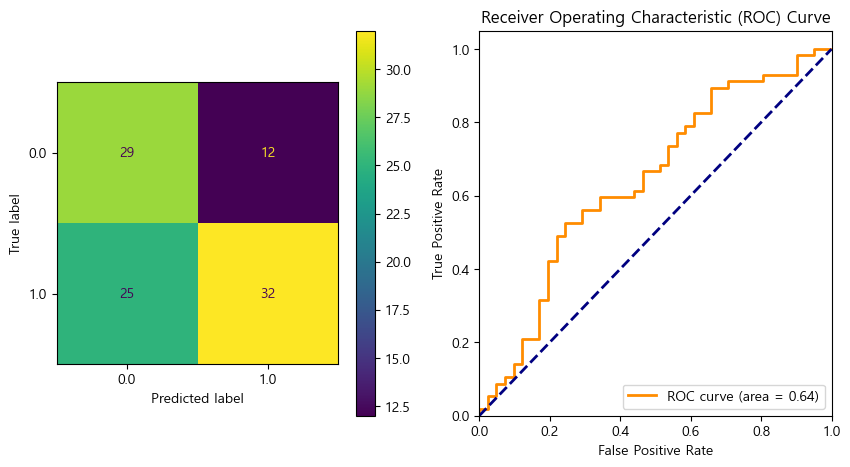

In [ ]:
# 로지스틱 회귀 Ridge / 변화율

from sklearn.linear_model import LogisticRegression

df_m = df_month.dropna()[filter]

df_X = df_m.iloc[:,4:-2]
df_y = df_m.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge 로지스틱 회귀 모델 설정
ridge_lr = LogisticRegression(penalty='l2', C=1, random_state=17)  # C는 정규화의 역수; 낮을수록 더 강한 정규화
ridge_lr.fit(X_train_scaled, y_train)

y_pred = ridge_lr.predict(X_test_scaled)
y_pred_proba = ridge_lr.predict_proba(X_test_scaled)[:,1]

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr.classes_)
disp.plot(ax=ax1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

정확도: 0.6122448979591837
정밀도: 0.611764705882353
재현도: 0.9122807017543859


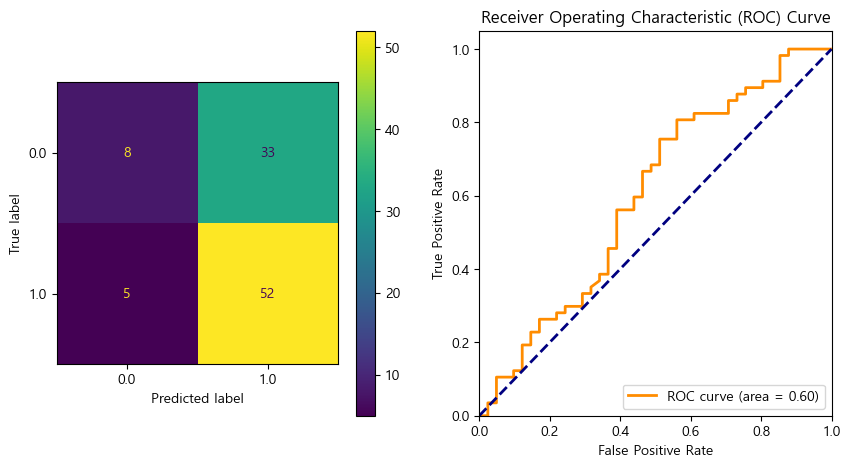

In [ ]:
# LASSO 로지스틱 회귀 / 변화율

lasso_lr = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=17)
lasso_lr.fit(X_train_scaled, y_train)

y_pred = lasso_lr.predict(X_test_scaled)
y_pred_proba = lasso_lr.predict_proba(X_test_scaled)[:,1]

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr.classes_)
disp.plot(ax=ax1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

정확도: 0.6804123711340206
정밀도: 0.6511627906976745
재현도: 0.9824561403508771


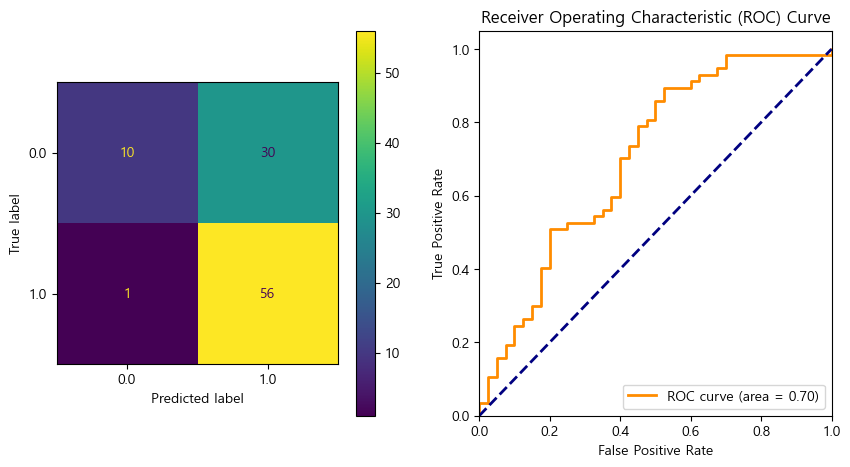

In [ ]:
# 로지스틱 회귀 Ridge / 변화율 / 한달 후

df_m = df_month.dropna()[filter]

gap = 1

df_X = df_m.iloc[:-gap,4:-2]
df_y = df_m.iloc[gap:,-1]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge 로지스틱 회귀 모델 설정
ridge_lr_1m = LogisticRegression(penalty='l2', C=1, random_state=17)  # C는 정규화의 역수; 낮을수록 더 강한 정규화
ridge_lr_1m.fit(X_train_scaled, y_train)

y_pred = ridge_lr_1m.predict(X_test_scaled)
y_pred_proba = ridge_lr_1m.predict_proba(X_test_scaled)[:,1]

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr_1m.classes_)
disp.plot(ax=ax1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

정확도: 0.6804123711340206
정밀도: 0.696969696969697
재현도: 0.8070175438596491


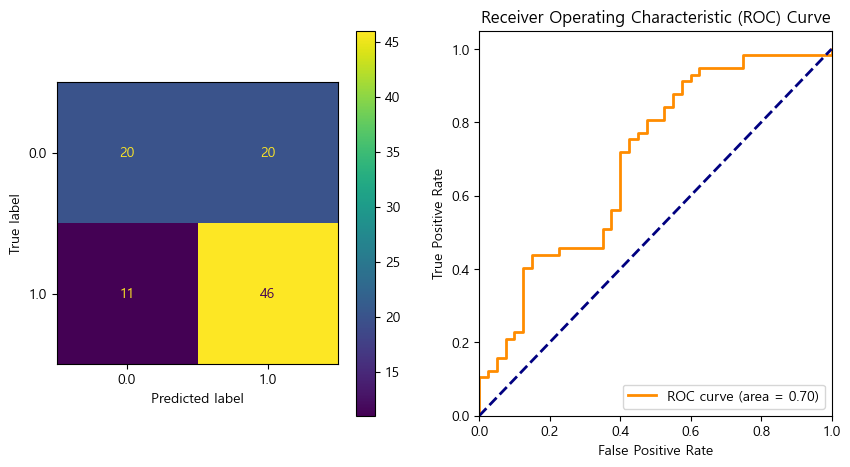

In [ ]:
# LASSO 로지스틱 회귀 / 한달 후 / 변화율 

lasso_lr_1m = LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=17)
lasso_lr_1m.fit(X_train_scaled, y_train)

y_pred = lasso_lr_1m.predict(X_test_scaled)
y_pred_proba = lasso_lr_1m.predict_proba(X_test_scaled)[:,1]

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr.classes_)
disp.plot(ax=ax1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
df_coef = pd.DataFrame()
df_coef['name'] = df_month.columns[4:-2]
df_coef['ridge'] = ridge_lr.coef_.tolist()[0]
df_coef['ridge_1m'] = ridge_lr_1m.coef_.tolist()[0]
df_coef['lasso'] = lasso_lr.coef_.tolist()[0]
df_coef['lasso_1m'] = lasso_lr_1m.coef_.tolist()[0]

df_coef

,name,ridge,ridge_1m,lasso,lasso_1m
0,m2,-0.319230,0.507172,0.000000,0.139852
1,unemploy,-0.125379,0.271315,0.000000,0.169768
2,interest,-0.586502,-0.079537,0.000000,-0.142869
3,copper,0.512829,-0.128146,0.000000,0.000000
4,UMCSENT,0.532818,0.613594,0.000000,0.466164
5,conflicts,-0.251901,-0.484360,0.000000,-0.269678
6,pro-con,-0.356441,-0.677961,-0.158351,-0.625948


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
정확도: 0.5567010309278351
정밀도: 0.6129032258064516
재현도: 0.6666666666666666
최적의 파라미터: {'rf__bootstrap': False, 'rf__max_depth': None, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
최적의 점수: 0.5182608695652173


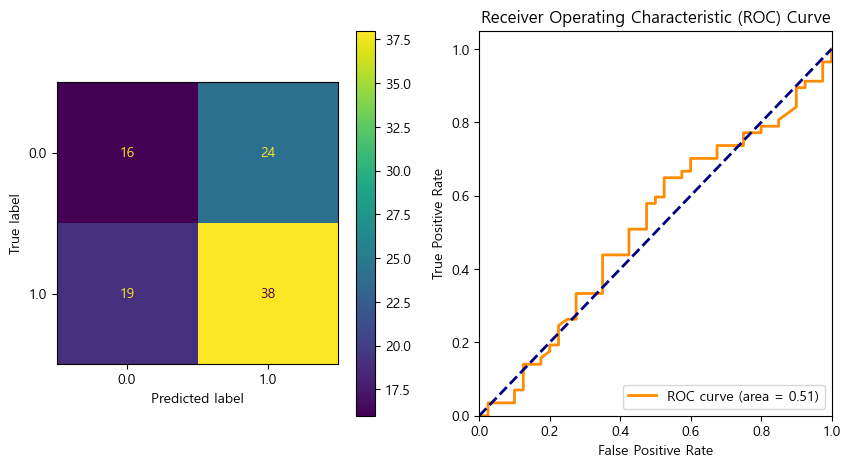

In [ ]:
# Random Forest 분류 / 1달 후

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 파이프라인 설정
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 데이터 스케일링
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))  # 랜덤 포레스트 모델
])

param_grid = {
    'rf__n_estimators': [10, 50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

y_pred = grid_search.predict(X_test_scaled)
y_pred_proba = grid_search.predict_proba(X_test_scaled)[:,1]


print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

print("최적의 파라미터:", grid_search.best_params_)
print("최적의 점수:", grid_search.best_score_)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr.classes_)
disp.plot(ax=ax1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
최적의 파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
최적의 점수: 0.557487922705314
테스트 세트 정확도: 0.6082474226804123


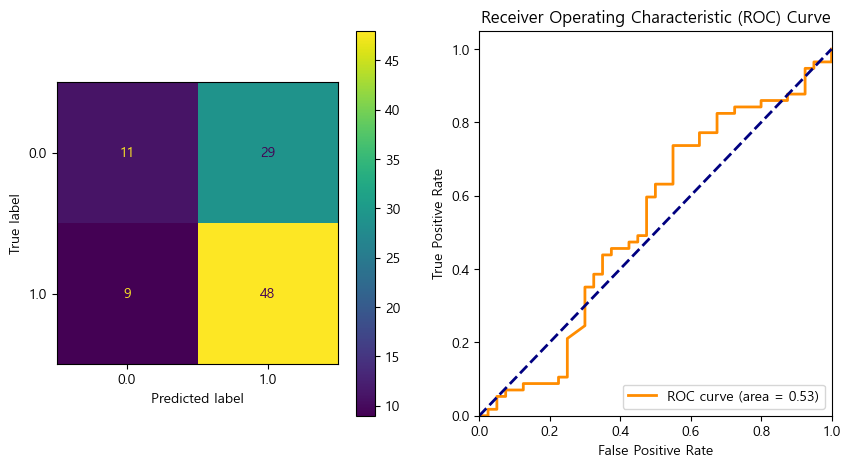

In [ ]:
# XGBoost

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

# XGBoost 분류기 설정
xgb_clf = xgb.XGBClassifier(random_state=-17)

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train_scaled, y_train)
print("최적의 파라미터:", grid_search.best_params_)
print("최적의 점수:", grid_search.best_score_)

# 최적의 모델로 예측
y_pred = grid_search.predict(X_test_scaled)
y_pred_proba = grid_search.predict_proba(X_test_scaled)[:,1]
print("테스트 세트 정확도:", accuracy_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr.classes_)
disp.plot(ax=ax1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()